In [3]:
1+1

2

In [1]:
import re
from functools import partial

## Preparing the List of Prime Gaps

The file `raw_prime_gaps_list.txt` contains the list of known lead prime gaps for all gaps up to $9998$. The data is uniformly stored. A typical row looks like the following, and the meaning of each element of the row is described below.

    6* CFC Glaisher 1877   1.91     2  23
    || |   |        |      |        |  |
    || |   |        |      |        |  ---> first prime in the prime gap
    || |   |        |      |        ------> number of digits of the first prime
    || |   |        |      ---------------> "merit", which is bigger if the gap is bigger wrt prime size
    || |   |        ----------------------> year of discovery
    || |   -------------------------------> discoverer
    || -----------------------------------> C if "conventional gap" (all here are)
    ||                                      F if known first occurrence of gap size, N if not, ? if unknown
    ||                                      C if certified primes, P if probabilistic primes
    |-------------------------------------> * if a "maximal gap", larger than all previous gaps
    --------------------------------------> size of gap
    
Sometimes the first prime is stored not as a number, but as an expression in the form $a \cdot b\# / c - d$, where $b\#$ denotes a *primorial*, or as an expression in the form $2^a + b$. We first read in the list. We extract those rows which are maximal (i.e. has * following the gapsize). Then we keep the gap size and the first prime.

In [2]:
with open("raw_prime_gaps_list.txt", "r") as f:
    lines = f.readlines()
print(lines[3])

     6* CFC Glaisher 1877   1.91     2  23



In [3]:
def is_maximal_gap(splitlist):
    if "*" in splitlist[0]:
        return True
    return False

def extract_gap_and_prime(line):
    splitlist = line.split(None, 6) # Split on whitespace (None), and make at most 6 splits
                                    # Splitting at most 6 times keeps the expression for the first prime together
    gap_str = splitlist[0]
    first_prime_str = splitlist[6]
    first_prime_str = first_prime_str.rstrip()
    
    #assert gap_str[-1] == "*"
    if gap_str[-1] == "*":
        gap = gap_str[:-1]
    else:
        gap = gap_str
    gap = int(gap)
    
    if "*" in first_prime_str:
        first_prime = extract_primorial(first_prime_str)
    elif "^" in first_prime_str:
        first_prime = extract_two_power_prime(first_prime_str)
    else:
        first_prime = int(first_prime_str)
        
    return gap, first_prime


def memoize(f):
    memo = {}
    def helper(x):
        if x not in memo:            
            memo[x] = f(x)
        return memo[x]
    return helper


primes_to_541 = primes_first_n(100)
@memoize
def primorial(n):
    return prod([p for p in primes_to_541 if p<= n])


def extract_primorial(expression):
    pattern = re.compile(r"(\w+)\W*\*\W*(\w+)\W*\#\W*/\W*(\w+)\W*-\W*(\w+)")
    m = pattern.match(expression)
    a,b,c,d = map(int, m.groups())
    return a*primorial(b)/c - d


def extract_two_power_prime(expression):
    pattern = re.compile(r"2\^(\w+)\W*\+\W*(\w+)")
    m = pattern.match(expression)
    exp, addend = map(int, m.groups())
    return 2**exp + addend

In [4]:
# First we test the method on just the first 10 prime gaps
gaps = []
gaps_dict = dict()
for line in lines[:10]:
    gap, first_prime = extract_gap_and_prime(line)
    gaps.append(gap)
    gaps_dict[gap] = [first_prime, first_prime + gap]

In [5]:
# These are the gaps
gaps

[1, 2, 4, 6, 8, 10, 12, 14, 16, 18]

In [6]:
# Clear prime pair storage
gaps_dict

{1: [2, 3],
 2: [3, 5],
 4: [7, 11],
 6: [23, 29],
 8: [89, 97],
 10: [139, 149],
 12: [199, 211],
 14: [113, 127],
 16: [1831, 1847],
 18: [523, 541]}

In [7]:
# First we test the method on just the first 10 prime gaps
gaps = []
gaps_dict = dict()
for line in lines:
    gap, first_prime = extract_gap_and_prime(line)
    gaps.append(gap)
    gaps_dict[gap] = [first_prime, first_prime + gap]

In [8]:
# Choose random representative to check
gaps_dict[116]

[5845193, 5845309]

## Setting up the model functions

We will model the distribution of primes in a few different ways. The nature of the distribution of primes is uncertain. By the prime number theorem, the average prime gap looks like
$$ X, X + \log X.$$
We expect instead that there are many gaps that are much larger. Cramer thought that prime gaps were never larger than
$$ X, X + \log^2 X.$$
It turns out that he wasn't correct, but it may be true that there is a constant $B$ such that gaps are never larger than
$$ X, X + B \log^2 X.$$
It is known that this constant, if it exists, is at least $2e^{-\gamma} \approx 1.1$.
It is also conjectured that no such constant exists, but that for any $A > 2$ there exists a corresponding constant (which I also denote by $B$) such that gaps are never larger than
$$ X, X + B \log^A X.$$

Recall in the background that we conjecture that for each $\alpha$ there exists a constant $C(\alpha)$ such that
$$ p_{n+1}^\alpha - p_n^\alpha \leq C(\alpha).$$

We will model how gaps behave according to these models and compare them to the actual behavior.
To do this, we define the function
$$ f(A, B, \alpha, x) := (X + B \log^A X)^\alpha - X^\alpha.$$
For each fixed $A, B$, and $\alpha$, maximizing $f_{A, B, \alpha}(x)$ gives a largest-possible estimate of the value of $C(\alpha)$. We say largest-possible because this presupposes that there are primes at exactly the maximizing value of $x$, which corresponds to $x$ and $x + B \log^A x$ being primes themselves.

Note that if Cramer's Conjecture were true (for instance), then it may be that the $C(\alpha)$ predictions we get from the Cramer model might be slightly larger than reality, and in general each model errs on the side of overestimating rather than underestimating.

We will set up model functions with values of $(A, B)$ being $(1,1)$ (PNT), $(2,1)$ (Naive Cramer), $(2,2e^{-\gamma})$ (Current Cramer), $(2, 10)$ (Cramer), and $(2.5, 1)$ (Adleman-McCurley).

### Maximizing the model functions

Maximizing $f_{A,B,\alpha}(x)$ is done naively. Compute the derivative and find when it's zero. There is a unique zero greater than $1$, which is our maximum point. A first-order estimation shows that $f_{A,B,\alpha}$ is maximized near $m(A,B,\alpha) = e^{A/(1-\alpha)}$. Note that $B$ does not affect this first-order estimation, so I do not expect the three variants of Cramer to behave significantly differently.

We have that
$$ \begin{align}
f(A, B, \alpha, x) &= (x + B \log^A x)^\alpha - x^\alpha, \\
f'(A, B, \alpha, x) &= \alpha(x + B \log^A x)^{\alpha - 1} \left( 1 + AB \frac{\log^{A-1} x}{x} \right) - \alpha x^{\alpha - 1}.
\end{align}$$

Note that $f' = 0$ (for $x > 1$) is the same as $f'/(\alpha x^{\alpha - 1}) = 0$, which can be rearranged into
$$ g_{A, B, \alpha}(x) := \left( 1 + AB \frac{\log^{A-1} x}{x} \right) - \left( 1 + B \frac{\log^A x}{x} \right)^{1 - \alpha} = 0.$$

This is a pretty well-behaved function, and numerical root solvers should be able to handle it. This is what we implement now.

In [9]:
def F(A, B, alpha, x):
    return (x + B*log(x)**A)**alpha - x**alpha

In [10]:
def g(A, B, alpha, x):
    return (1 + A * B * log(x)**(A-1)/x) - (1 + B*log(x)**A / x)**(1-alpha)

In [11]:
find_root(partial(g,2,1,.931), 2, 10**17)

3875382310049.5977

Actually, this caps out at 17 digit precision and won't suffice for $\alpha > 0.93$. But for really large $x$, the binomial expansion should become more and more accurate, leading to $e^{A/(1-\alpha)}$ being a better and better estimate of the maximizing $x$. For $\alpha > 0.93$, I need to use a different technique. This runs into 64-bit precision arithmetic problems. To solve this, for $\alpha > 0.9$, I will use a homegrown bisection rootfinder in a high precision arithmetic sage environment.

In [12]:
RF = RealField(1000)
def RF_F(A, B, alpha, x):
    return (RF(x) + B*RF(log(x))**A)**alpha - RF(x)**alpha

In [13]:
start = exp(2/.005)

In [14]:
RF_F(2, 1, .995, start)

21545.3770912687021748108986403427084075846916931792212525384307640395688240237337048227691696804791326950035399102608956974569724349727991073964722581240384122762528927904117476919639364452675336235413841573393011675588938510358312010132614449997916430297316353906271329030935986082731144694523430359

In [15]:
def RF_g(A, B, alpha, x):
    return (RF(1) + A * B * RF(log(x))**(A-1)/RF(x)) - (RF(1) + B*RF(log(x))**A / RF(x))**(1-alpha)

In [16]:
def RF_gsim(x):
    return RF_g(2,1,0.8,x)

In [17]:
start = exp(2/.2)

In [18]:
RF_gsim(start)

1.64444546432196045785420540155893726063200274572267336535350345517820986134145980935118162918424805451405780491393962735635632068351784816308968439342270391699018760425327496611550914706761553155070977740717893810316453496034348416368377098158251454957552350910050505616367388235938291760692342296640e-6

In [19]:
find_root(RF_gsim, 2, 10**17)

22423.973931885273

In [20]:
# Note that this requires that func(2*start) < 0 to work properly
# In our case, this means that the `start` guess can't be too bad
def bisection_rootfinding(func, start, iterations=1, goal=10**(-7)):
    if start*2**(-iterations) < goal:
        return start
    if func(start) > 0:
        return bisection_rootfinding(func, start + start * 2**(-iterations), iterations=iterations+1, goal=goal)
    return bisection_rootfinding(func, start - start * 2**(-iterations), iterations=iterations+1, goal=goal)

In [21]:
bisection_rootfinding(RF_gsim, start)

22423.9739319633

Notice in particular that this is essentially the same as scipy's find_root result, so my method seems to work pretty well.

Now let's try it on something larger.

In [22]:
def RF_gsim2(x):
    return RF_g(2,1,0.95,x)

In [23]:
start = RF(exp(2/.05))

In [24]:
find_root(RF_gsim2, 2, 10**16)

9999999710581220.0

In [25]:
bisection_rootfinding(RF_gsim2, start)

2.35385266837042022843327073581445209550189717806195566505913760542398087081961498860906821406821821384500066808118082097402013219336066587283757576744855862678903728952660301215698355426390611932122470916392998635276106218830903304888702478640727370013260828376486514621410432957225533987162136976562e17

In [26]:
fr = find_root(RF_gsim2, 2, 10**16)
br = bisection_rootfinding(RF_gsim2, start)

In [27]:
br/fr

23.538527364953389

In [28]:
RF_F(2,1,0.95,br)

205.709630519650881691924521792765193253506704662129143200009919811578164796694847391279127980866813238127336707532494092877547455355110417039290138055484169795377093169784536561532277570158710114624712809121313730522096004967342309066003863302396648990201591070015928728914879882408923972678419871216

In [29]:
RF_F(2,1,0.95,fr)

204.359554823890368403363980346311818555686040610577329335810851723660578683578255065736205720488148424074134614592141667900060298707050938806333994911863866233402912888249520944989763989818618341662786563588774804722056915716107185579765431262102230328894524070859044620196971152617523013227880281789

This is interesting --- there is a region in which find_root fails due to precision reasons, but not in an obviously detectable way. But as this clearly shows, my bisection method suffices.

## Data Creation

The plan is to loop through $\alpha$ from $0.005$ to $0.995$, compute everything, and compare everything. But for many initial $\alpha$, everything is boring. Let's first find exactly when $\alpha$ is boring.

In [30]:
def estimate_c_alpha(alpha):
    MAX = 0
    MAXIMIZING_PRIME = 0
    MAXIMIZING_GAP = 0
    for gap in gaps:  # Note: It is possible to optimize this selection based on vals for other alpha
        a,b = gaps_dict[gap]
        diff = RF(b)**alpha - RF(a)**alpha
        if diff > MAX:
            MAX = diff
            MAXIMIZING_PRIME = a
            MAXIMIZING_GAP = gap
    return MAX, MAXIMIZING_GAP, MAXIMIZING_PRIME

In [31]:
for a in range(20):
    alpha = 0.05 + 0.04 * a
    print alpha, estimate_c_alpha(alpha)

0.0500000000000000 (0.0273310781848302800658590880398522815347590177971289917771832998742533538405129347101901809408899390154774514006487716615848197146224848388750750143388527967917247425289525849885984701315952214994461518869467334113477417254612430110708981668255496105519249618121865605658797754277991125986546424926508, 2, 3)
0.0900000000000000 (0.0519370809347252520685872649136154113889575896783660909311486774384967763294410100201853785718930335741505701554636256358169356949220163741754562328432777159041140235202911046252875832381116056987398716939257761619006205913299310880723598291675100978615964192750372577866405938486631637439508364320858, 2, 3)
0.130000000000000 (0.0792030225749460145408332846210646211349709553727122695589775991379642815865105358693876664136993146934495792581811221651860043234387972830839584009007088431244195480057541946715422880580136690530288636745487275691029720040890241179152279971140525502557180885918952288021915731111539843731655078009650, 2, 3)
0.170000

It appears that starting at $\alpha = 0.005$ will be fine, though not a lot happens until $\alpha \approx 0.5$. The semiimportant data there is really just the value of $C(\alpha)$.

Let us now set up the data structures to store the data. These will be a set of dictionaries, contained in a "model" dictionary.

In [32]:
experimental_model = dict()
PNT_model = dict()
naive_cramer_model = dict()
current_cramer_model = dict()
weak_cramer_model = dict()
AM_model = dict()

models = dict()
models["experimental"] = experimental_model
models["PNT"] = PNT_model
models["naive"] = naive_cramer_model
models["current"] = current_cramer_model
models["weak"] = weak_cramer_model
models["AM"] = AM_model

In each model dictionary, the keys will be values of $\alpha$ from $0.005$ to $0.995$, and the values will be `(C(alpha), gap, lower_prime)` tuples. That's that.

I'll store the data as pickled dictionaries, and as json dumps (for external portability).

In [33]:
RF = RealField(1000)
def RF_F(A, B, alpha, x):
    return (RF(x) + B*RF(log(x))**A)**alpha - RF(x)**alpha

def RF_g(A, B, alpha, x):
    return (RF(1) + A * B * RF(log(x))**(A-1)/RF(x)) - (RF(1) + B*RF(log(x))**A / RF(x))**(1-alpha)


def maximize_model(A, B, alpha):
    fun = lambda x: RF_F(A, B, alpha, x)
    deriv = lambda x: RF_g(A, B, alpha, x)
    estimate_lower_prime = 2*RF(exp(A/(1 - alpha)))
    lower_prime = bisection_rootfinding(deriv, start)
    Calpha = fun(lower_prime)
    gap = B*log(lower_prime)**A
    return (Calpha, gap, lower_prime)

In [34]:
def make_experimental_data(alpha):
    Calpha, gap, lower_prime = estimate_c_alpha(alpha)
    return (Calpha, gap, lower_prime)

def make_model_data(A, B, alpha):
    return maximize_model(A,B,alpha)

def make_PNT_model_data(alpha):
    return make_model_data(1,1,alpha)

def make_naive_model_data(alpha):
    return make_model_data(2,1,alpha)

def make_current_model_data(alpha):
    return make_model_data(2,1.1229189671337703396, alpha)

def make_weak_model_data(alpha):
    return make_model_data(2, 10, alpha)

def make_AM_model_data(alpha):
    return make_model_data(2.1, 1, alpha)

In [35]:
for a in range(1000):
    alpha = 0.000 + a/1000
    models["experimental"][alpha] = make_experimental_data(alpha)
    models["PNT"][alpha] = make_PNT_model_data(alpha)
    models["naive"][alpha] = make_naive_model_data(alpha)
    models["current"][alpha] = make_current_model_data(alpha)
    models["weak"][alpha] = make_weak_model_data(alpha)
    models["AM"][alpha] = make_AM_model_data(alpha)
    if a%50 == 0:
        print a

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


In [36]:
#t = models.keys()[0]
#for k in models[t].keys():
#    print k
#    for key in models.keys():
#        print key, "{}".format(float(models[key][k][0]))
#    print

In [37]:
alist = models['experimental'].keys()

In [38]:
alist = sorted(alist)
alist[:10]

[0.000000000000000,
 0.00100000000000000,
 0.00200000000000000,
 0.00300000000000000,
 0.00400000000000000,
 0.00500000000000000,
 0.00600000000000000,
 0.00700000000000000,
 0.00800000000000000,
 0.00900000000000000]

In [39]:
models['experimental'][alist[-50]]

(186.266539364655933626490915855618094964571041849497438999997826389079814853291919149871340027107619054174485385512758967203039410422848728780559014112645466156493093420011269068962647210601068265065442552646499480648773915312419366944230198770879264447877675770996717230251871662312084943372625852009,
 1132,
 1693182318746371)

In [40]:
exp_plotys = [models['experimental'][a][0] for a in alist]
cur_plotys = [models['current'][a][0] for a in alist]
weak_plotys = [models['weak'][a][0] for a in alist]
naive_plotys = [models['naive'][a][0] for a in alist]
pnt_plotys = [models['PNT'][a][0] for a in alist]
am_plotys = [models['AM'][a][0] for a in alist]

In [41]:
exp_plotys[:10]

[0,
 0.000511517768525288490431299564019530566521268528293360224090648225671358406177645208427960618154537414232201941218446425306818783533501147565303119802041928147556730502807612639983069318331337966366989636147947059894660635945989823381565534871988347392491415512712789530278446363938930989574701960971573,
 0.00102442172449282884332508157534822491563469058472756719379918434497150349164072269796738895556658217479601021664620351202402928247792955884906721383928526283258088661094103784976857592343906755172954042356731975418539998880830592392230883140406784021001485475079790186985430084990582641020616554607448,
 0.00153871471873605261609594567254478753444623540399582289121122633476589317565823494066369723602547767528506869164326737509390842483499917786372877323718544377009408577779985644905224201012604546334079646010266208402550801858445699818597717680152286230410860527428679105037060870377855630342605362083545,
 0.00205439960735970041704645998947656177812210389930506653845904193767730

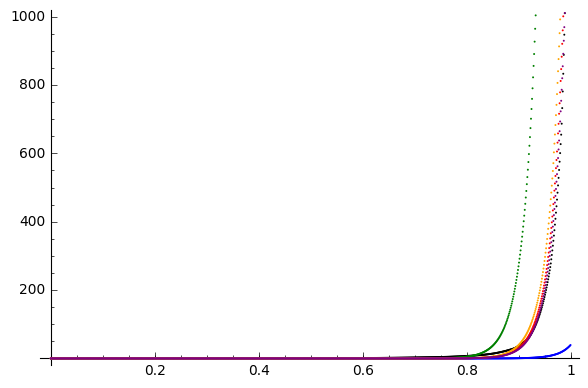

In [195]:
P = scatter_plot(zip(alist, exp_plotys), xmin=0, xmax=0.995, ymin=0, ymax=1000, markersize=2, facecolor='black', edgecolor='')
P += scatter_plot(zip(alist, cur_plotys), markersize=2, facecolor='red', edgecolor='')
P += scatter_plot(zip(alist, weak_plotys), markersize=2, facecolor='green', edgecolor='')
P += scatter_plot(zip(alist, pnt_plotys), markersize=2, facecolor='blue', edgecolor='')
P += scatter_plot(zip(alist, am_plotys), markersize=2, facecolor='orange', edgecolor='')
P += scatter_plot(zip(alist, naive_plotys), markersize=2, facecolor='purple', edgecolor='')
P

In [55]:
alpha_in_8_to_10 = []
for a in range(200):
    alpha = 0.8 + 0.001 * a
    print "\r" + str(alpha),
    alpha_in_8_to_10.append((alpha, estimate_c_alpha(alpha)[0]))

0.999000000000000    


In [56]:
alpha_in_8_to_10[:10]

[(0.800000000000000,
  7.26014575499710583007752218476427663828926179611157953282726566695049107265377270133560692997036040530500477768867195065477012290917719308708782018245669078582044688607873551418902354119005826714341041787179613542691696812731368111577302778025140783938715803646904732042037141424376103751080011998710),
 (0.801000000000000,
  7.34488929791419664639472074261502192281957152607915337406435419916315200585249998380204802464158172422854707558003676849509272095842610708260861187394075385302864085424482425636215460071693157771352179388596036196527196233733066745050675507537225353771965938807629237803255305635045814031962805504380),
 (0.802000000000000,
  7.43061042252953118360499889585345215018025636058791613024779180241959349552833645769717749958099242955401006554977231966370929595157074587453403662539834509389164431402822851597631998341664334362076793184715469597355362017466344732729542069893132901288343947966821105638284381796933618371826846838619),
 (0.803000000000000

In [58]:
alphaprime = []
yprime = []
for tup in alpha_in_8_to_10:
    alpha, y = tup
    alphaprime.append(log(1-alpha))
    yprime.append(log(y))

In [60]:
alphaprime[:5]

[-1.60943791243410,
 -1.61445045425764,
 -1.61948824828760,
 -1.62455155024415,
 -1.62964061975162]

In [61]:
yprime[:5]

[1.98239990508105792432914206584034425361291820164801420571371447279489000805005017210551940329748997949158276953758402139559706347895794635989738106647433102557324635006924478567083315201989122813678874733027136858749688442475437260290841954181034549727611229670749280412218485884946091336845146816553,
 1.99400473775108917242607592672379876282962602758486599176148576772489434639025636624056896545690094280224195809733448464124202508093422016580455567072652267572463293430462118712221270594276058468607769040072042105653811588064721872113903111728451820492918543610398905495968245410433690439953389342567,
 2.00560801181928100231139813531008896336733947147889255572229770276025059061492979832016543643104245292920992912477217573183288125389017314482489589303875686728543697919670636242183802728761179540256596711814791281490102327649928484622757922109228990643321882068823404558914950808859897896899546791065,
 2.0172097311700019683724920859460117860241800518073088343914274715762093605301121727404

In [62]:
zip(alphaprime[:5], yprime[:5])

[(-1.60943791243410,
  1.98239990508105792432914206584034425361291820164801420571371447279489000805005017210551940329748997949158276953758402139559706347895794635989738106647433102557324635006924478567083315201989122813678874733027136858749688442475437260290841954181034549727611229670749280412218485884946091336845146816553),
 (-1.61445045425764,
  1.99400473775108917242607592672379876282962602758486599176148576772489434639025636624056896545690094280224195809733448464124202508093422016580455567072652267572463293430462118712221270594276058468607769040072042105653811588064721872113903111728451820492918543610398905495968245410433690439953389342567),
 (-1.61948824828760,
  2.00560801181928100231139813531008896336733947147889255572229770276025059061492979832016543643104245292920992912477217573183288125389017314482489589303875686728543697919670636242183802728761179540256596711814791281490102327649928484622757922109228990643321882068823404558914950808859897896899546791065),
 (-1.62455155024415

In [67]:
var('A')
var('B')
model(x) = B - A*x

In [68]:
find_fit(zip(alphaprime, yprime), model)

[A == 1.6670411794480962, B == -0.28990653254233467]

This indicates that the exponent from the linear fit is 1.66, which is not so good. I suspect what's happening is the lack of sufficiently large prime gaps means that the experimental data for alpha very near $1$ is simply incorrect. So let's cut out the highest portion of the range.

In [148]:
# From 0.8 to 0.95
LOWER = 0
UPPER = 150
alphaprime_9 = alphaprime[LOWER:UPPER]
yprime_9 = yprime[LOWER:UPPER]
find_fit(zip(alphaprime_9, yprime_9), model)

[A == 2.38952780953096, B == -1.8741114946012887]

In [149]:
# From 0.85 to 0.95
LOWER = 50
UPPER = 150
alphaprime_9 = alphaprime[LOWER:UPPER]
yprime_9 = yprime[LOWER:UPPER]
find_fit(zip(alphaprime_9, yprime_9), model)

[A == 2.3838016290728183, B == -1.8595471688135894]

Wow, look at the stability of that result.

In [150]:
# From 0.8 to 0.9
LOWER = 0
UPPER = 100
alphaprime_9 = alphaprime[LOWER:UPPER]
yprime_9 = yprime[LOWER:UPPER]
find_fit(zip(alphaprime_9, yprime_9), model)

[A == 2.381841660510989, B == -1.8594294921692536]

In [151]:
# From 0.8 to 0.85
LOWER = 0
UPPER = 50
alphaprime_9 = alphaprime[LOWER:UPPER]
yprime_9 = yprime[LOWER:UPPER]
find_fit(zip(alphaprime_9, yprime_9), model)

[A == 2.3446674868637274, B == -1.7982001515169852]

The sheer stability of this in these ranges indicates to me that maybe there is something here. What if we eek just a little bit more out of the upper range?

In [153]:
# From 0.8 to 0.96
LOWER = 0
UPPER = 160
alphaprime_9 = alphaprime[LOWER:UPPER]
yprime_9 = yprime[LOWER:UPPER]
find_fit(zip(alphaprime_9, yprime_9), model)

[A == 2.3517182353898307, B == -1.7986473277851818]

In [154]:
# From 0.8 to 0.97
LOWER = 0
UPPER = 170
alphaprime_9 = alphaprime[LOWER:UPPER]
yprime_9 = yprime[LOWER:UPPER]
find_fit(zip(alphaprime_9, yprime_9), model)

[A == 2.2790797480846114, B == -1.6504264401594178]

The guess really plummets when we increase from 0.96 to 0.97, so I would guess that this is around where the prime gaps peter off.

Let's use the model data on the range $\alpha \leq 0.8 < 0.95$. On this range, we have

    A' = 2.3895
    B' = -1.874
    
I use $A'$ and $B'$ to denote that this is what the model estimates. The estimate for $A$ is exactly $A'$, so we guess that $A \approx 2.3895$. The estimate for $B$ is a bit more complicated, and work in my notebook RN5.28 shows that $B \approx \exp(B' - A' \log(A'/e))$.

In [184]:
# From 0.8 to 0.95
var('A')
var('B')
model(x) = B - A*x
LOWER = 0
UPPER = 150
alphaprime_9 = alphaprime[LOWER:UPPER]
yprime_9 = yprime[LOWER:UPPER]
res = find_fit(zip(alphaprime_9, yprime_9), model, solution_dict=True)


In [186]:
Aprime = res[A]
Bprime = res[B]
print Aprime, Bprime

2.38952780953 -1.8741114946


In [190]:
exper_A = Aprime
exper_B = exp(Bprime - Aprime * log(Aprime / e))
exper_B = exper_B.n()
print exper_A, exper_B

2.38952780953 0.208859966269026


Hmm, interesting. The growth estimate appears to be overcompensating and tossing more into the exponent and taking away from the coefficient.

As an additional experiment, shat if we force the leading coefficient to be $-1$? I'm not quite sure what this would mean, but sometimes one must play a trombone to petunias.

In [200]:
# From 0.8 to 0.95
var('A')
var('B')
model(x) = -1 - A*x
LOWER = 0
UPPER = 150
alphaprime_9 = alphaprime[LOWER:UPPER]
yprime_9 = yprime[LOWER:UPPER]
res = find_fit(zip(alphaprime_9, yprime_9), model, solution_dict=True)
Aprime = res[A]
print Aprime

1.99402560961


In [201]:
exper_A = Aprime
exper_B = exp(-1 - Aprime * log(Aprime / e))
exper_B = exper_B.n()
print exper_A, exper_B

1.99402560961 0.682384387756181


It's amusingly close to causing the exponent to be $2$, but otherwise it is not particularly meaningful.